# MODELOS CLASIFICACION - DATA TABULAR <a id="modelos"></a> 

# Introducción <a id="introduction"></a>
Como fue comentado inicialmente, la idea de aplicar estos modelos de clasificación es hacer foco en identificar grupos de clientes que demuestren un comportamiento particular hacia los servicios de la empresa y su satisfacción con los mismos. Dicha identificación genera la base informativa necesaria para buscar mejorar esa satisfacción y la consecuente reputación de la empresa, como así también aplicar una pluralidad de estrategias de fidelización y/o atracción de determinados perfiles, decisiones que van a cuenta de la empresa.
Vamos a hacer varias pruebas para encontrar el mejor modelo de clasificación basado en F1-Score para predecir reviewscore. Para la preparación de datos se eliminaran variables que a priori no usaremos, se crearán dummies, se estatificara la data, se probarán métodos de balance de datos, reduccion de features y distintas técnicas de clasificación de machine learning. Después de eso, trazaremos la mejor interacción del árbol de decisión de los modelos con su feature_importance. Luego haremos un pipeline y exportaremos el modelo.

[Volver al menu](#top)

## Importar librerías  <a id="libmodelos"></a>

In [88]:
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold
import warnings
import warnings
warnings.filterwarnings("ignore")

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler 

#Método de balance de datos
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks

#Metricas de Evaluacion de modelos
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectKBest, f_classif,RFECV,RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, r2_score, auc
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# Clasificadores
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Tunning modelos
from hyperopt import fmin, tpe, hp, anneal, Trials, STATUS_OK
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# Importancia de variables y ploteo del arbol
from xgboost import plot_tree

# guardado del modelo
import joblib

import seaborn
import matplotlib.pyplot as plt

[Volver al menu](#top)

## Preparación de la data  <a id="prepdata"></a>

In [89]:
df_full=df.reset_index()

In [90]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95815 entries, 0 to 95814
Data columns (total 44 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   index                        95815 non-null  int64  
 1   order_status                 95815 non-null  object 
 2   seller_id                    95815 non-null  object 
 3   price                        95815 non-null  float64
 4   freight_value                95815 non-null  float64
 5   payment_type                 95814 non-null  object 
 6   payment_value                95814 non-null  float64
 7   review_score                 95815 non-null  float64
 8   product_category_name        94471 non-null  object 
 9   product_photos_qty           94471 non-null  float64
 10  product_weight_g             95799 non-null  float64
 11  product_length_cm            95799 non-null  float64
 12  product_height_cm            95799 non-null  float64
 13  product_width_cm

Ploteamos una matriz correlación para asegurarnos que ninguna variable este relacionada con el target

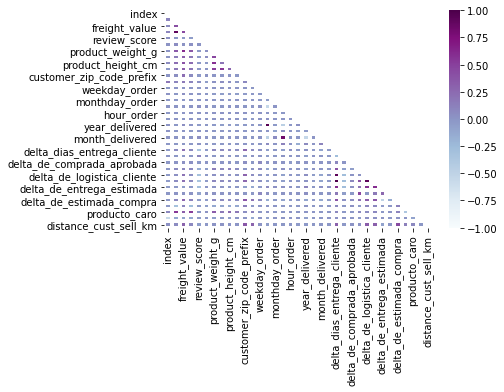

In [91]:
corr_df = df_full.corr()

mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)] = True

seaborn.heatmap(corr_df, cmap='BuPu', vmax=1.0, vmin=-1 ,mask = mask,  linewidths=3,fmt='.1f')
 
plt.yticks(rotation=0,fontsize=10) 
plt.xticks(rotation=90,fontsize=10) 
plt.show()

In [92]:
corr_df

,index,price,freight_value,payment_value,review_score,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,...,delta_de_aprobada_logistica,delta_de_logistica_cliente,delta_de_comprada_cliente,delta_de_entrega_estimada,delta_de_logistica_limit,delta_de_estimada_compra,precio_relativo_envío,producto_caro,seller_experimentado,distance_cust_sell_km
index,1.000000,0.101453,0.066446,0.090290,0.036858,0.016684,0.008784,0.007856,0.060536,-0.015986,...,-0.012783,-0.029898,-0.033466,-0.027356,-0.000814,-0.004554,-0.021955,0.075010,-0.559703,0.026224
price,0.101453,1.000000,0.419182,0.907578,-0.005469,0.049856,0.344204,0.144987,0.233147,0.174288,...,0.066376,0.037449,0.060285,-0.008765,0.012214,0.075226,-0.311424,0.544409,-0.122837,0.060778
freight_value,0.066446,0.419182,1.000000,0.451616,-0.034830,0.022761,0.614829,0.313992,0.390824,0.329392,...,0.083001,0.197795,0.214869,-0.044327,0.009459,0.283232,0.089782,0.329554,-0.090226,0.294224
payment_value,0.090290,0.907578,0.451616,1.000000,-0.041214,0.031092,0.363717,0.161321,0.247921,0.184823,...,0.075911,0.041531,0.068875,-0.018694,0.014319,0.095958,-0.270283,0.510715,-0.120008,0.077653
review_score,0.036858,-0.005469,-0.034830,-0.041214,1.000000,0.013936,-0.028948,-0.019486,-0.017095,-0.012193,...,-0.155726,-0.299629,-0.334266,-0.266721,-0.083190,-0.053010,-0.024718,-0.003092,-0.025043,-0.059291
product_photos_qty,0.016684,0.049856,0.022761,0.031092,0.013936,1.000000,0.028087,0.048256,-0.027482,0.011578,...,-0.040060,-0.013877,-0.026947,0.003663,0.019171,-0.033269,-0.058420,0.021533,-0.000867,-0.010948
product_weight_g,0.008784,0.344204,0.614829,0.363717,-0.028948,0.028087,1.000000,0.465043,0.581543,0.513984,...,0.138011,0.030355,0.079950,0.010089,0.015912,0.074693,-0.111725,0.337000,-0.059577,0.012155
product_length_cm,0.007856,0.144987,0.313992,0.161321,-0.019486,0.048256,0.465043,1.000000,0.193920,0.549324,...,0.083062,0.036119,0.064525,0.008642,0.007643,0.059706,-0.097485,0.160475,-0.021705,0.012467
product_height_cm,0.060536,0.233147,0.390824,0.247921,-0.017095,-0.027482,0.581543,0.193920,1.000000,0.287537,...,0.117669,0.018015,0.060516,-0.002914,0.014822,0.068719,-0.123031,0.249408,-0.054069,0.004133
product_width_cm,-0.015986,0.174288,0.329392,0.184823,-0.012193,0.011578,0.513984,0.549324,0.287537,1.000000,...,0.061657,0.019685,0.040909,-0.000467,0.006893,0.044719,-0.121080,0.171337,0.001588,0.003601


Respecto al target,  no hay alguna correlación fuerte que indique eliminar una variable en particular de nuestro modelo.

**Eliminamos columnas que no utilizaremos**

In [93]:
drop_elements=['index', 'customer_unique_id',
       'seller_id']
df_full = df_full.drop(drop_elements, axis = 1)

In [94]:
df_full.shape

(95815, 41)

In [95]:
df_full.columns

Index(['order_status', 'price', 'freight_value', 'payment_type',
       'payment_value', 'review_score', 'product_category_name',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'seller_zip_code_prefix',
       'seller_city', 'seller_state', 'weekday_order', 'year_order',
       'monthday_order', 'month_order', 'hour_order', 'weekday_delivered',
       'year_delivered', 'monthday_delivered', 'month_delivered',
       'hour_delivered', 'delta_dias_entrega_cliente',
       'delta_dias_responder_review', 'delta_de_comprada_aprobada',
       'delta_de_aprobada_logistica', 'delta_de_logistica_cliente',
       'delta_de_comprada_cliente', 'delta_de_entrega_estimada',
       'delta_de_logistica_limit', 'delta_de_estimada_compra',
       'precio_relativo_envío', 'producto_caro', 'seller_experimentado',
       'distance_cust_sell_km'],
      dtype='object')

[Volver al menu](#top)

### División Target Review Score en Postivos y Negativos <a id="target"></a>

In [96]:
labels = []
for score in df_full['review_score']:
    if score > 3:
        labels.append(1)
        
    else:
        labels.append(0)


In [97]:
full_df = df_full   
full_df['review_score'] = labels

In [98]:
full_df["review_score"].value_counts()

1    75638
0    20177
Name: review_score, dtype: int64

In [99]:
full_df['review_score'].value_counts()/np.float(len(full_df))

1    0.789417
0    0.210583
Name: review_score, dtype: float64

In [100]:
full_df.columns

Index(['order_status', 'price', 'freight_value', 'payment_type',
       'payment_value', 'review_score', 'product_category_name',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'seller_zip_code_prefix',
       'seller_city', 'seller_state', 'weekday_order', 'year_order',
       'monthday_order', 'month_order', 'hour_order', 'weekday_delivered',
       'year_delivered', 'monthday_delivered', 'month_delivered',
       'hour_delivered', 'delta_dias_entrega_cliente',
       'delta_dias_responder_review', 'delta_de_comprada_aprobada',
       'delta_de_aprobada_logistica', 'delta_de_logistica_cliente',
       'delta_de_comprada_cliente', 'delta_de_entrega_estimada',
       'delta_de_logistica_limit', 'delta_de_estimada_compra',
       'precio_relativo_envío', 'producto_caro', 'seller_experimentado',
       'distance_cust_sell_km'],
      dtype='object')

In [101]:
full_df.shape

(95815, 41)

**Variables Categoricas / Variables Numericas**

In [102]:
categorical=['customer_city', 'customer_state','seller_city', 'seller_state','order_status','payment_type','product_category_name'] 
columnas_num=['price', 'freight_value', 'payment_value',
       'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'customer_zip_code_prefix', 'seller_zip_code_prefix', 'weekday_order',
       'year_order', 'monthday_order', 'month_order', 'hour_order',
       'weekday_delivered', 'year_delivered', 'monthday_delivered',
       'month_delivered', 'hour_delivered', 'delta_dias_entrega_cliente',
       'delta_dias_responder_review', 'delta_de_comprada_aprobada',
       'delta_de_aprobada_logistica', 'delta_de_logistica_cliente',
       'delta_de_comprada_cliente', 'delta_de_entrega_estimada',
       'precio_relativo_envío', 'delta_de_logistica_limit',
       'delta_de_estimada_compra', 'producto_caro', 'seller_experimentado',
       'distance_cust_sell_km']

In [103]:
full_df[categorical]=full_df[categorical].astype('category')
full_df.dtypes

order_status                   category
price                           float64
freight_value                   float64
payment_type                   category
payment_value                   float64
review_score                      int64
product_category_name          category
product_photos_qty              float64
product_weight_g                float64
product_length_cm               float64
product_height_cm               float64
product_width_cm                float64
customer_zip_code_prefix          int64
customer_city                  category
customer_state                 category
seller_zip_code_prefix          float64
seller_city                    category
seller_state                   category
weekday_order                     int64
year_order                        int64
monthday_order                    int64
month_order                       int64
hour_order                        int64
weekday_delivered                 int64
year_delivered                    int64


**Eliminamos posibles nan**

In [104]:
full_df = full_df.dropna(axis =0 , how = 'any')

[Volver al menu](#top)

## Funciones modelaje <a id="funcionesmodelaje"></a>

* Veremos el balance de clases en el dataset con un value counts de la columna review_score
* Haceremos un train-test-split estratificado
* Convertiremos las variables categoricas a dummy. Conviene que nos quedemos con una versión no dummy del dataset de entrenamiento puesto que luego usaremos SMOTENC
* Armararemos una función que tome como input un modelo entrenado y un dataset de testeo e imprima las métricas más importantes para evaluar clasificación (classification_report, matriz de confución, area bajo las curvas ROC y Precision-Recall)
* Instanciaremos un modelo Random Forest, lo entrenaremos y evaluaremos en el dataset de testeo

### Balance de Clases <a id="balanceclases"></a>

In [105]:
def evaluate_model(model,X,y_true):
    '''
    Calcula las métricas ppales para evaluar un clasificador
    Toma como imput el modelo entrenado, el dataset de testeo y sus etiquetas
    '''
    y_pred=model.predict(X)
    y_proba=model.predict_proba(X)

    print(classification_report(y_true,y_pred))
    print('Area bajo la curva ROC:',np.round(roc_auc_score(y_true,y_proba[:,1]),4))
    precision, recall,threshold=precision_recall_curve(y_true,y_proba[:,1]);
    print('Area bajo la curva Precision-Recall:',np.round(auc(recall,precision),4))
    plot_confusion_matrix(model,X,y_true,cmap='BuPu');
    return

In [106]:
full_df['review_score'].value_counts(normalize=True)

1    0.789698
0    0.210302
Name: review_score, dtype: float64

[Volver al menu](#top)

#### División Train Split  <a id="split"></a> 

In [107]:
# Train test split

X_train,X_test,y_train,y_test=train_test_split(full_df.drop('review_score',axis=1),full_df['review_score'],\
                                               stratify=full_df['review_score'],random_state=0,test_size=0.2)


In [108]:
X_test.shape,X_train.shape

((18894, 40), (75575, 40))

In [109]:
escalador =  StandardScaler() 
X_train[columnas_num]=escalador.fit_transform(X_train[columnas_num]) 
X_test[columnas_num]=escalador.transform(X_test[columnas_num])

**Creamos dummies y chequeamos que tengan las mismas dimensiones**

In [110]:
X_train_dummy=pd.get_dummies(X_train)
X_test_dummy=pd.get_dummies(X_test)
print('Mismas categorías en Train y Test:',(X_train_dummy.columns==X_test_dummy.columns).all())

Mismas categorías en Train y Test: True


[Volver al menu](#top)

### Resampling de las clases <a id="resampling"></a>

* Haremos un undersampling de la clase mayoritaria en el training set para balancear las clases y veremos como quedó el dataset de entrenamiento.
* Volveremos a entrenar un random forest y evaluarlo en test.
* Repetiremos el procedimiento usando SMOTENC para sobresamplear la clase minoritaria.
* Instanciaremos un Random Forest usando class_weight='balanced_subsample', entrenarlo en el training set original (sin resampling) y lo evaluaremos en test set

* Combinaremos las tres estrategias anteriores:
- Undersampling
- Oversampling
- Class weight

Usaremos una combinación de undersampling y oversampling optimizando esta, mediante cross-validation. Utiliczaremos una combinación de sampling_stategy que de por resultado un dataset de tamaño reducido respecto del original. Usaremos ese dataset para hacer feature selection.

In [111]:
# UnderSampling del dataset
sampler=RandomUnderSampler()
X_train_us,y_train_us=sampler.fit_resample(X_train_dummy,y_train)
print('X_train_us:',X_train_us.shape)
print('\nBalance de clases en train:')
print(y_train_us.value_counts())

print('\n\nX_test:',X_test_dummy.shape)
print('\nBalance de clases en test:')
print(y_test.value_counts())

X_train_us: (31788, 4838)

Balance de clases en train:
1    15894
0    15894
Name: review_score, dtype: int64


X_test: (18894, 4838)

Balance de clases en test:
1    14921
0     3973
Name: review_score, dtype: int64


DATASET SUBSAMPLEADO
              precision    recall  f1-score   support

           0       0.36      0.50      0.42      3973
           1       0.85      0.76      0.81     14921

    accuracy                           0.71     18894
   macro avg       0.61      0.63      0.61     18894
weighted avg       0.75      0.71      0.72     18894

Area bajo la curva ROC: 0.6874
Area bajo la curva Precision-Recall: 0.8715


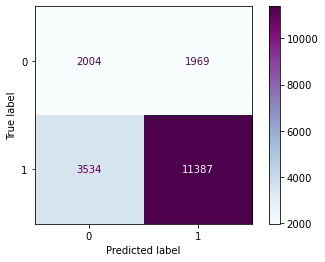

In [112]:
model=RandomForestClassifier()
model.fit(X_train_us,y_train_us)
print('DATASET SUBSAMPLEADO')
evaluate_model(model,X_test_dummy,y_test)

In [113]:
print('DATASET SOBRESAMPLEADO')
categorical_mask=(X_train.dtypes=='category').values
sm=SMOTENC(categorical_features=categorical_mask,sampling_strategy='minority')
X_train_os,y_train_os=sm.fit_resample(X_train,y_train)
X_train_os=pd.get_dummies(X_train_os)

print('X_train_os:',X_train_os.shape)
print('\nBalance de clases en train:')
print(y_train_os.value_counts())

print('\n\nX_test:',X_test_dummy.shape)
print('\nBalance de clases en test:')
print(y_test.value_counts())

DATASET SOBRESAMPLEADO
X_train_os: (119362, 4838)

Balance de clases en train:
1    59681
0    59681
Name: review_score, dtype: int64


X_test: (18894, 4838)

Balance de clases en test:
1    14921
0     3973
Name: review_score, dtype: int64


              precision    recall  f1-score   support

           0       0.57      0.30      0.39      3973
           1       0.83      0.94      0.88     14921

    accuracy                           0.80     18894
   macro avg       0.70      0.62      0.64     18894
weighted avg       0.78      0.80      0.78     18894

Area bajo la curva ROC: 0.6828
Area bajo la curva Precision-Recall: 0.869


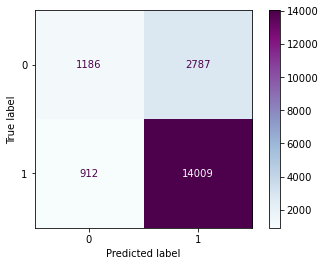

In [114]:
model=RandomForestClassifier()
model.fit(X_train_os,y_train_os)
evaluate_model(model,X_test_dummy,y_test)

              precision    recall  f1-score   support

           0       0.83      0.21      0.33      3973
           1       0.82      0.99      0.90     14921

    accuracy                           0.82     18894
   macro avg       0.83      0.60      0.61     18894
weighted avg       0.82      0.82      0.78     18894

Area bajo la curva ROC: 0.6861
Area bajo la curva Precision-Recall: 0.8678


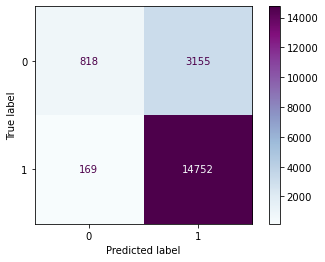

In [115]:
# Balance de clases
model=RandomForestClassifier(class_weight='balanced_subsample')
model.fit(X_train_dummy,y_train)
evaluate_model(model,X_test_dummy,y_test)

In [116]:
# Combinando Estrategias
sampler=RandomUnderSampler(sampling_strategy=0.5)
X,y=sampler.fit_resample(X_train,y_train)
sm=SMOTENC(categorical_mask,sampling_strategy=0.8)
X_train_rs,y_train_rs=sm.fit_resample( X,y)

X_train_rs=pd.get_dummies(X_train_rs)
if not (X_test_dummy.columns==X_train_rs.columns).all():
    print('Train y Test tienen distintas Categorias:')
    print('Usar OneHotEncoding')

print(y_train_rs.shape)
print(y_train_rs.mean())

(57218,)
0.5555594393372715


              precision    recall  f1-score   support

           0       0.53      0.33      0.41      3973
           1       0.84      0.92      0.88     14921

    accuracy                           0.80     18894
   macro avg       0.68      0.63      0.64     18894
weighted avg       0.77      0.80      0.78     18894

Area bajo la curva ROC: 0.6921
Area bajo la curva Precision-Recall: 0.8719


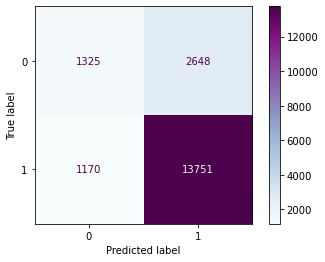

In [117]:
# Balance de clases
model=RandomForestClassifier(class_weight='balanced_subsample')
model.fit(X_train_rs,y_train_rs)
evaluate_model(model,X_test_dummy,y_test)

[Volver al menu](#top)

### Selección de Features <a id="selecfeatures"></a>

#### SelectKBest
Primero seleccionaremos featuers usando SelectKbest tomando como medida de score el criterio 'f_classif'

* Haceremos un pipeline que concatene el selector de features y un RandomForestClassifier con class_weight='balanced_subsample'
* Haceremos una gridsearchCV variando el parámetro k del selector de features. Usar scoring='f1'.
* Graficaremos los resultados del procedimiento de cross-validation: scores de clasificacion vs nro de features
* Graficaremos la importancia de las features para el modelo.

In [118]:
# Seleccion de features:
skf=StratifiedKFold(n_splits=3,shuffle=True,random_state=0)
steps=([('selector',SelectKBest(f_classif)),('classif',RandomForestClassifier(class_weight='balanced_subsample'))])
pipe=Pipeline(steps)
param_grid={'selector__k':np.arange(10,300,20)}
grid=GridSearchCV(pipe,param_grid,scoring='f1',cv=skf,verbose=3,n_jobs=3)
grid.fit(X_train_rs,y_train_rs)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  5.8min
[Parallel(n_jobs=3)]: Done  45 out of  45 | elapsed: 10.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('selector', SelectKBest()),
                                       ('classif',
                                        RandomForestClassifier(class_weight='balanced_subsample'))]),
             n_jobs=3,
             param_grid={'selector__k': array([ 10,  30,  50,  70,  90, 110, 130, 150, 170, 190, 210, 230, 250,
       270, 290])},
             scoring='f1', verbose=3)

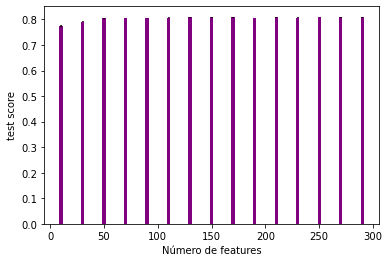

In [119]:
n_features=grid.cv_results_['param_selector__k'].data
mn_cv_score=grid.cv_results_['mean_test_score']
err=grid.cv_results_['std_test_score']
plt.bar(n_features,mn_cv_score,color = "purple",width=3,yerr=err,align = "center")
plt.xlabel('Número de features')
plt.ylabel('test score');

              precision    recall  f1-score   support

           0       0.51      0.33      0.40      3973
           1       0.84      0.91      0.87     14921

    accuracy                           0.79     18894
   macro avg       0.67      0.62      0.64     18894
weighted avg       0.77      0.79      0.77     18894

Area bajo la curva ROC: 0.6884
Area bajo la curva Precision-Recall: 0.8714


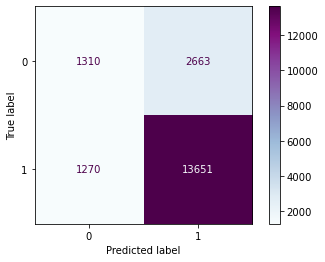

In [120]:
# Evaluamos en test
skb=SelectKBest(f_classif,k=70)
X_train_reduced=skb.fit_transform(X_train_rs,y_train_rs)
X_test_reduced=X_test_dummy.loc[:,skb.get_support()]
model=RandomForestClassifier(class_weight='balanced_subsample')
model.fit(X_train_reduced,y_train_rs)
evaluate_model(model,X_test_reduced,y_test)

(0.0, 30.0)

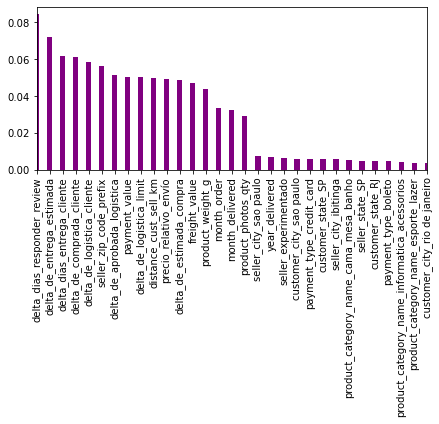

In [121]:
y=np.sort(model.feature_importances_)
x=np.argsort(model.feature_importances_)
x=x[::-1]
feat_names=X_train_rs.columns[skb.get_support()]
labels=feat_names[x]
y=y[::-1]

plt.figure(figsize=(7,3))
plt.bar(range(len(y)),y,color = "purple",width=0.4,align = "center")
plt.xticks(range(len(y)), labels, rotation=90)

plt.xlim([0,30])

In [122]:
X_test_reduced.shape, X_train_reduced.shape

((18894, 70), (57218, 70))

In [123]:
 y_train_rs.shape, y_test.shape

((57218,), (18894,))

[Volver al menu](#top)

# Metodología Modelos Clasificacion <a id="methodologymodels"></a>

El DF estába muy desequilibrado con reviewscores negativoss como la clase minoritaria. Veremos, cuál es el mejor métodos de clasificación.
En una primera instancia se van a construir funciones para facilitar el proceso.

## Evaluación de métricas - Precision, Recall and F1-Score <a id='evaluate'>

Para evaluar los modelos de clasificación binaria usaremos Precision , Recall, F1-Score, Especificity y Area b/curva ROC.

In [124]:
def Model_Score(model, y_test, X_test):

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    
    total_score = {'Recall':[recall_score(y_test, y_pred, pos_label=1,average='binary')],
                   'Precision': [precision_score(y_test, y_pred, pos_label=1,average='binary')],
                   'F1_Score' : [f1_score(y_test, y_pred, pos_label=1,average='binary')],
                   'Especificity': [recall_score(y_test, y_pred, pos_label=0,average='binary')],
                   'Area b/curva ROC': [np.round(roc_auc_score(y_test,y_proba[:,1]),4)]
                   }
    
    total_score = pd.DataFrame(total_score, columns = ['Recall','Precision','F1_Score','Especificity',
                                                       'Area b/curva ROC'])   
    return total_score


In [125]:
def expo_metricas(model, y_test, X_test):

    y_pred = model.predict(X_test)
    
    """Función que recibe valores de 'y' reales,
    valores de 'y' predichos y 
    devuelve metricas principales"""
    
    print("\nAccuracy:", accuracy_score(y_test, y_pred))
    print("\nAUROC:", roc_auc_score(y_test, y_pred))
    print("\nF1-Score:", f1_score(y_test, y_pred, average = 'weighted'))
    print("\nClasification Report:")
    print(metrics.classification_report(y_test, y_pred))
    print("\nMatriz de confusion:")
    
    sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt='d',cmap='BuPu')
    plt.show();
 

[Volver al menu](#top)

## Algoritmos de clasificación <a id='classification'>

Probaremos cuatro algoritmos de clasificación
* Regresión Logistica
* Decision Tree Classifier
* Random Forest Classifier
* Extreme Gradient Boosting


[Volver al menu](#top)

## Test de modelos<a id='mt'>

Al final, se devolverá una tabla con la precisión de recuperación y la puntuación f1 basada en los datos brutos del conjunto de pruebas para los 4 modelos diferentes.


In [126]:
def Models_Binary_Classification(X_train, X_test, y_train, y_test):

    ## train split
    X_train_1, X_test_1,y_train_1, y_test_1 = X_train, X_test,y_train, y_test
    
    # 1 - Logistic Regression 
    ### LR
    LR_1 = LogisticRegression()
    LR_1.fit(X_train_1, y_train_1)
    LR_score_1 = Model_Score(LR_1, y_test_1, X_test_1)
    print("\nLogistic Regression:")
    LR_score_1_2 = expo_metricas(LR_1, y_test_1, X_test_1)
           
    # 2 - Decision Tree Classifier (DTC) 
    ###  DTC
    DTC_1 = DecisionTreeClassifier(random_state=0, max_depth=5)
    DTC_1.fit(X_train_1, y_train_1)
    DTC_score_1 = Model_Score(DTC_1, y_test_1, X_test_1)
    print("\nDecision Tree Classifier")
    DTC_score_1_2 = expo_metricas(DTC_1, y_test_1, X_test_1)
       
    # 3 - Ramdon Forrest  Classifier (RFC) 
    ###  RFC
    RFC_1 = RandomForestClassifier(random_state=0, max_depth=5)
    RFC_1.fit(X_train_1, y_train_1)
    RFC_score_1 = Model_Score(RFC_1, y_test_1, X_test_1)
    print("\nRamdon Forrest  Classifier")
    RFC_score_1_2 = expo_metricas(RFC_1, y_test_1, X_test_1)
    
    # 4 - XGBC Classifier (XGBC) 
    # XGBC 
    XGBC_1 = xgb.XGBClassifier(random_state=0, max_depth=5)
    XGBC_1.fit(X_train_1, y_train_1)
    XGBC_score_1 = Model_Score(XGBC_1, y_test_1, X_test_1)
    print("\nXGBC Classifier")
    XGBC_score_1_2 = expo_metricas(XGBC_1, y_test_1, X_test_1)
    
   # Best F1_Score
    
    Score = {'Methods': ['LR - Logistic Regression',
                                    'DTC - Decision Tree Classifier',
                                    'RFC - Ramdon Forrest  Classifier',
                                    'XGBC - XG Boost Classifier'
                                   ],
                        
                             'Recall': [LR_score_1["Recall"][0],
                                        DTC_score_1["Recall"][0],
                                        RFC_score_1["Recall"][0],
                                        XGBC_score_1["Recall"][0]
                                       ],
             
                          'Precision': [LR_score_1["Precision"][0],
                                        DTC_score_1["Precision"][0],
                                        RFC_score_1["Precision"][0],
                                        XGBC_score_1["Precision"][0]
                                       ],
             
                           'F1_Score': [LR_score_1["F1_Score"][0],
                                        DTC_score_1["F1_Score"][0],
                                        RFC_score_1["F1_Score"][0],
                                        XGBC_score_1["F1_Score"][0]
                                       ],   
             
                       'Especificity': [LR_score_1["Especificity"][0],
                                        DTC_score_1["Especificity"][0],
                                        RFC_score_1["Especificity"][0],
                                        XGBC_score_1["Especificity"][0]
                                       ],
             
                   'Area b/curva ROC': [LR_score_1["Area b/curva ROC"][0],
                                        DTC_score_1["Area b/curva ROC"][0],
                                        RFC_score_1["Area b/curva ROC"][0],
                                        XGBC_score_1["Area b/curva ROC"][0]
                                       ]
                           }
    
    score_results = pd.DataFrame(Score)

    return score_results

**Corremos los modelos para nuestra data ya balanceada y con features seleccionadas previamente.**


Logistic Regression:

Accuracy: 0.7407642637874458

AUROC: 0.6279199825684844

F1-Score: 0.7451534734475701

Clasification Report:
              precision    recall  f1-score   support

           0       0.39      0.43      0.41      3973
           1       0.84      0.82      0.83     14921

    accuracy                           0.74     18894
   macro avg       0.62      0.63      0.62     18894
weighted avg       0.75      0.74      0.75     18894


Matriz de confusion:


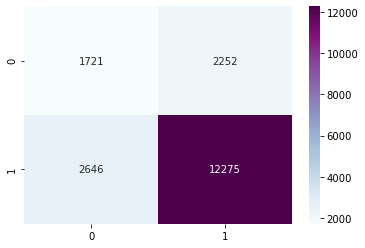


Decision Tree Classifier

Accuracy: 0.7966550227585477

AUROC: 0.6167671592916417

F1-Score: 0.7749888829626499

Clasification Report:
              precision    recall  f1-score   support

           0       0.53      0.31      0.39      3973
           1       0.83      0.93      0.88     14921

    accuracy                           0.80     18894
   macro avg       0.68      0.62      0.63     18894
weighted avg       0.77      0.80      0.77     18894


Matriz de confusion:


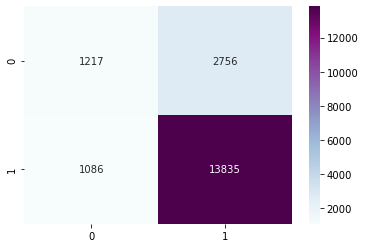


Ramdon Forrest  Classifier

Accuracy: 0.8048057584418334

AUROC: 0.6137094410796771

F1-Score: 0.778069881911784

Clasification Report:
              precision    recall  f1-score   support

           0       0.57      0.28      0.38      3973
           1       0.83      0.94      0.88     14921

    accuracy                           0.80     18894
   macro avg       0.70      0.61      0.63     18894
weighted avg       0.78      0.80      0.78     18894


Matriz de confusion:


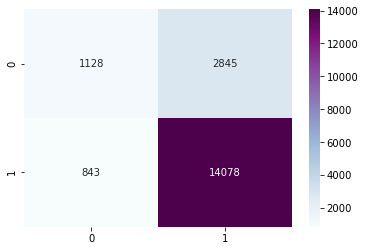

[16:25:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

XGBC Classifier

Accuracy: 0.8043823436011432

AUROC: 0.6317246163294483

F1-Score: 0.7847319771273319

Clasification Report:
              precision    recall  f1-score   support

           0       0.56      0.33      0.42      3973
           1       0.84      0.93      0.88     14921

    accuracy                           0.80     18894
   macro avg       0.70      0.63      0.65     18894
weighted avg       0.78      0.80      0.78     18894


Matriz de confusion:


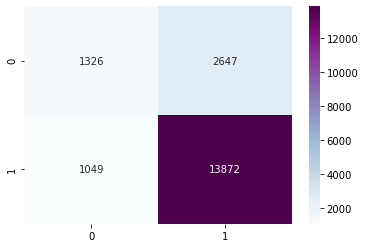

Wall time: 14.9 s


In [127]:
%time score_df_full = Models_Binary_Classification(X_train_reduced, X_test_reduced, y_train_rs, y_test)

# Resultados de los metodos de evaluación <a id='rme'>

In [128]:
#Resultados Full df
full_methods = score_df_full.sort_values(by=['F1_Score'],ascending=False).reset_index(drop=True)
full_methods

,Methods,Recall,Precision,F1_Score,Especificity,Area b/curva ROC
0,RFC - Ramdon Forrest Classifier,0.943502,0.831886,0.884185,0.283916,0.6787
1,XGBC - XG Boost Classifier,0.929696,0.839760,0.882443,0.333753,0.7013
2,DTC - Decision Tree Classifier,0.927217,0.833886,0.878078,0.306318,0.6592
3,LR - Logistic Regression,0.822666,0.844978,0.833673,0.433174,0.6690


[Volver al menu](#top)

# Tuning modelos <a id='tbm'>


## XGBoost  <a id='XGBoost'>

Para ajustar debemos encontrar los mejores parámetros para max_depth, learning_ratte y n_esttimators. A continuación, entrenamos el modelo con los parámetros, trazamos una confusion_matrix y definimos una df con los resultados de Precision Recall y F1-Score.


In [129]:
def gb_mse_cv( params, random_state=0, cv=4, X = X_train_reduced, y = y_train_rs):
   

    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
              'learning_rate': int(params['learning_rate'])
             }

    model = xgb.XGBClassifier(random_state=0, **params)
    

    score = -cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
    

    return score

In [130]:
def GB_hyperopt(gb_mse_cv, X_train, y_train, X_test, y_test ):
    

    space={'max_depth': hp.quniform('max_depth',5,10,1),
            'learning_rate': hp.loguniform('learning_rate', -5, 0),
            'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),

    }

   # las pruebas contendrán información de registro
    trials = Trials()

    best=fmin(fn=gb_mse_cv, # función para optimizar
              space=space, # posibles valores de los parámetros
              algo=tpe.suggest, # algoritmo de optimización, hyperotp seleccionará sus parámetros automáticamente
              max_evals=5, # número máximo de iteraciones
              trials=trials # logging
             )
   
    model=xgb.XGBClassifier( n_estimators = int(best['n_estimators']),
                            max_depth = int(best['max_depth']),
                            learning_rate = best['learning_rate'],
                            

                           )
                   
    model.fit(X_train, y_train)

    tpe_test_score=mean_squared_error(y_test, model.predict(X_test))
    
    return print("Best MSE {:.3f} params {}".format( gb_mse_cv(best), best))

In [131]:
%time GB_hyperopt(gb_mse_cv, X_train_reduced, y_train_rs, X_test_reduced, y_test.values.ravel())

100%|███████████████████████████████████████████████████████████████| 5/5 [15:00<00:00, 180.20s/trial, best loss: -0.0]
[16:40:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best MSE -0.000 params {'learning_rate': 0.6702564201748157, 'max_depth': 5.0, 'n_estimators': 388.0}
Wall time: 17min 4s


In [132]:
clf_f_t = xgb.XGBClassifier(random_state = 0,
                           learning_rate = 0.6702564201748157,
                           max_depth = 5,
                           n_estimators = 388)

clf_f_t.fit(X_train_reduced,y_train_rs)

[16:42:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.033843896624649684, max_delta_step=0,
              max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=907, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)


Accuracy: 0.8006774637451043

AUROC: 0.6335342139968885

F1-Score: 0.7832380421127064

Clasification Report:
              precision    recall  f1-score   support

           0       0.54      0.35      0.42      3973
           1       0.84      0.92      0.88     14921

    accuracy                           0.80     18894
   macro avg       0.69      0.63      0.65     18894
weighted avg       0.78      0.80      0.78     18894


Matriz de confusion:


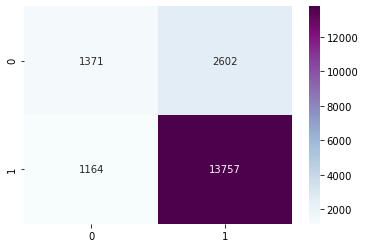

In [133]:
expo_metricas(clf_f_t, y_test, X_test_reduced)

In [134]:
score_f_t = Model_Score(clf_f_t, y_test, X_test_reduced)
score_f_t

,Recall,Precision,F1_Score,Especificity,Area b/curva ROC
0,0.921989,0.840944,0.879604,0.345079,0.6968


[Volver al menu](#top)

## Random Forest <a id='randomforest'>

In [135]:
forest = RandomForestClassifier(random_state=0, max_depth=5)
modelF = forest.fit(X_train_reduced, y_train_rs)
y_predF = modelF.predict(X_test_reduced)


Accuracy: 0.8048057584418334

AUROC: 0.6137094410796771

F1-Score: 0.778069881911784

Clasification Report:
              precision    recall  f1-score   support

           0       0.57      0.28      0.38      3973
           1       0.83      0.94      0.88     14921

    accuracy                           0.80     18894
   macro avg       0.70      0.61      0.63     18894
weighted avg       0.78      0.80      0.78     18894


Matriz de confusion:


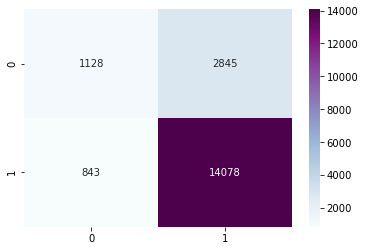

In [136]:
expo_metricas(modelF, y_test, X_test_reduced)

In [137]:
n_estimators = [1, 10, 100, 150] 
max_depth = [5, 8, 15, 25, 30] 
min_samples_split = [2, 3, 5, 10, 20] 
min_samples_leaf = [1, 2, 5, 10]

hyperF = dict (n_estimators = n_estimators, max_depth = max_depth,   
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf) 

gridF = GridSearchCV (forest, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1) 
bestF = gridF.fit (X_train_reduced, y_train_rs)

Fitting 3 folds for each of 400 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 33.2min finished


In [138]:
print("Best: %f using %s" % (bestF.best_score_, bestF.best_params_))

Best: 0.725175 using {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


In [139]:
forestOpt = RandomForestClassifier(random_state = 1, 
                                   max_depth = 30,     
                                   n_estimators = 150, 
                                   min_samples_split = 2, 
                                   min_samples_leaf = 1)
                                   
modelOpt = forestOpt.fit(X_train_reduced, y_train_rs)
y_pred = modelOpt.predict(X_test_reduced)


Accuracy: 0.7977664867153593

AUROC: 0.6243040007349387

F1-Score: 0.7783705559024072

Clasification Report:
              precision    recall  f1-score   support

           0       0.53      0.32      0.40      3973
           1       0.84      0.92      0.88     14921

    accuracy                           0.80     18894
   macro avg       0.68      0.62      0.64     18894
weighted avg       0.77      0.80      0.78     18894


Matriz de confusion:


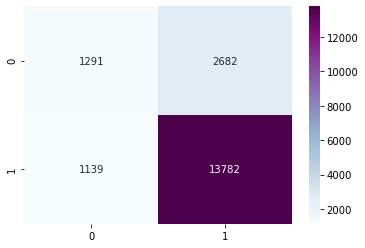

In [140]:
expo_metricas(modelOpt, y_test, X_test_reduced)

In [141]:
score_rf = Model_Score(modelOpt, y_test, X_test_reduced)
score_rf

,Recall,Precision,F1_Score,Especificity,Area b/curva ROC
0,0.923665,0.837099,0.878254,0.324943,0.6926


[Volver al menu](#top)

## Probamos un Modelo de Ensambles <a id='ensambles'>

Construiremos un modelo de ensamble usando como modelos base a una RL y los dos modelos tunneados anteriores.
Para esto, escribir la función `predict_proba_ensamble` que calcule la probabilidad de 1 como el promedio de las probabilidades respuesta de los predictores base.

Evaluaremos la performance del ensamble (usando como umbral 0.5) mediante

* AUC

* accuracy

* confusion_matrix


### Logistic Regression 


Logistic Regression:

Accuracy: 0.7407642637874458

AUROC: 0.6279199825684844

F1-Score: 0.7451534734475701

Clasification Report:
              precision    recall  f1-score   support

           0       0.39      0.43      0.41      3973
           1       0.84      0.82      0.83     14921

    accuracy                           0.74     18894
   macro avg       0.62      0.63      0.62     18894
weighted avg       0.75      0.74      0.75     18894


Matriz de confusion:


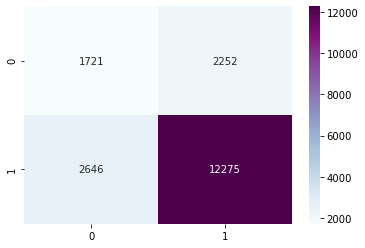

In [142]:
LR_1 = LogisticRegression()
LR_1.fit(X_train_reduced, y_train_rs)
LR_score_1 = Model_Score(LR_1, y_test, X_test_reduced)
print("\nLogistic Regression:")
expo_metricas(LR_1, y_test, X_test_reduced)

In [143]:
X=full_df.drop('review_score',axis=1)

In [144]:
def predict_proba_ensamble(X, LR_1, modelF, clf_f_t):
    y_pred_1 = LR_1.predict_proba(X)[:, 1]
    y_pred_2 = modelF.predict_proba(X)[:, 1]
    y_pred_3 = clf_f_t.predict_proba(X)[:, 1]
    result = (y_pred_1 + y_pred_2 + y_pred_3) / 3    
    return result

In [145]:
predict_ensemble = predict_proba_ensamble(X_test_reduced, LR_1, modelF, clf_f_t)
auc_ensemble = roc_auc_score(y_test, predict_ensemble)
print(auc_ensemble)

0.6988998843864876


El valor de AUC del ensamble es similar a la de xgboost tunned.

In [146]:
threshold = 0.5
predict_ensemble_cat = [1 if (x >= threshold) else 0 for x in predict_ensemble]  

accuracy_ensemble = accuracy_score(y_test, predict_ensemble_cat)
print(accuracy_ensemble)

confusion_matrix_ensemble = confusion_matrix(y_test, predict_ensemble_cat)
print(confusion_matrix_ensemble)

0.7979781941357045
[[ 1346  2627]
 [ 1190 13731]]


[Volver al menu](#top)

# Importancia de variables y Decision Tree Plot <a id='clfplot'>

Para trazar un modelo de clasificación XGBoost con los nombres de las variables, usamos la función plot_tree.


Como clasificador ganador en todos los marcos de datos fue el XGBoost, que funciona según el principio de conjunto. Los modelos están constituidos por muchos árboles. Para extraer la regla de decisión, tenemos que encontrar el número ordinal del mejor refuerzo de iteración para establecerlo como el parámetro "num_tree".

Para hacer eso usaremos dos funciones que lo configuran para nosotros .get_booster y .best_iteration.

Además, a continuación se define una función para trazar la importancia de las variables.

## Full DF - Decision Tree e importancia de variables <a name='fulldftree'>

In [147]:
clf_f_t.get_booster().best_iteration

906

In [148]:
def Feat_Importances(clf,X_train):
    
    feat_importances = pd.Series(clf.feature_importances_, index = X_train.columns).sort_values(ascending=False)[::-1]
    
    return feat_importances.nlargest(20).plot(kind='barh',color='#4B0082')

<AxesSubplot:>

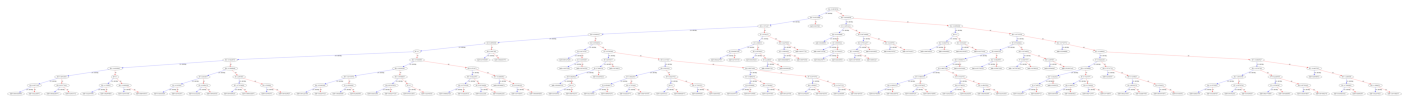

In [149]:
fig, ax = plt.subplots(figsize=(25, 50))  # whatever size you want
plot_tree(clf_f_t, ax=ax , num_trees=906)

(0.0, 30.0)

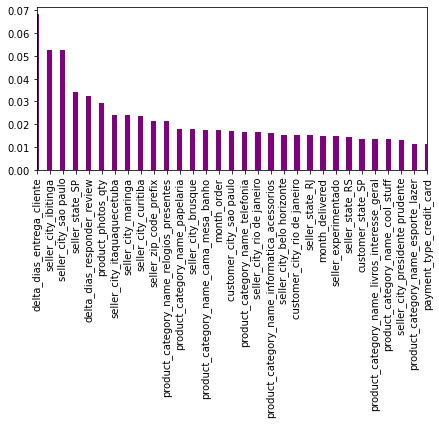

In [150]:
y=np.sort(clf_f_t.feature_importances_)
x=np.argsort(clf_f_t.feature_importances_)
x=x[::-1]
feat_names=X_train_rs.columns[skb.get_support()]
labels=feat_names[x]
y=y[::-1]

plt.figure(figsize=(7,3))
plt.bar(range(len(y)),y,color = "purple",width=0.4,align = "center")
plt.xticks(range(len(y)), labels, rotation=90)

plt.xlim([0,30])

[Volver al menu](#top)

## Pipeline <a id='pipline'>

In [151]:
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [152]:
# Train test split
X_train,X_test,y_train,y_test=train_test_split(full_df.drop('review_score',axis=1),full_df['review_score'],\
                                               stratify=full_df['review_score'],random_state=0,test_size=0.2)


In [153]:
numeric_features = ['price', 'freight_value', 'payment_value',
       'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'customer_zip_code_prefix', 'seller_zip_code_prefix', 'weekday_order',
       'year_order', 'monthday_order', 'month_order', 'hour_order',
       'weekday_delivered', 'year_delivered', 'monthday_delivered',
       'month_delivered', 'hour_delivered', 'delta_dias_entrega_cliente',
       'delta_dias_responder_review', 'delta_de_comprada_aprobada',
       'delta_de_aprobada_logistica', 'delta_de_logistica_cliente',
       'delta_de_comprada_cliente', 'delta_de_entrega_estimada',
       'precio_relativo_envío', 'delta_de_logistica_limit',
       'delta_de_estimada_compra', 'producto_caro', 'seller_experimentado',
       'distance_cust_sell_km']

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_features = ['customer_city', 'customer_state','seller_city', 'seller_state',
                        'order_status','payment_type','product_category_name']

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", xgb.XGBClassifier(random_state = 0, learning_rate = 0.6702564201748157, max_depth = 4, n_estimators = 388))]
                )


clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

[17:25:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
model score: 0.812


In [154]:
from sklearn import set_config

set_config(display="diagram")
clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['price', 'freight_value',
                                                   'payment_value',
                                                   'product_photos_qty',
                                                   'product_weight_g',
                                                   'product_length_cm',
                                                   'product_height_cm',
                                                   'product_width_cm',
                                                   'customer_zip_code_prefix',
                                                   'seller_zip_code_pref...
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.6702564201748157,
                               max_delta_step=0, max_depth=4,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=388,
                               n_jobs=8, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

[Volver al menu](#top)

## Guardado del modelo elegido <a id='saving'>

In [155]:
joblib.dump(clf,'full_df_model.sav')

['full_df_model.sav']

[Volver al menu](#top)

## Análisis final <a id='final'>

Eligimos como mejor modelo XGBoost porque resulto ser el más balanceado en todas las metricas. Si bien creemos que puede ser mejorada la presición para nuestra clase minoritaria, el score global es aceptable para clasificar las reviewscore y aplicar los distintos tratamientos de clientes para las campañas de email marketing. Seguiremos con nuestro proyecto en la notebook de Sentiment Analysis.